## Semi-Supervised Japanese Emails Classification

#### Abstract: 
          In our task, labelling more than 20,000 Japanese emails could not mission-impossible for supervised email classification. However, based on the trained model on the top of BERT, and one small set of labelling English emails, we may look for the data which is endorsed by both BERT and MLP ( accuracy level is very outstanding during training English email classification), and treat those as the labelled data like consensus rule. This program is working toward this direction.

This program is consisted of the following: <br />

1. By BERT and MLP, predict the categories of Japanese emails which have been translated into English by google translation - 2,276 emails, around 10% of total emails. <br />
<br />
2. Retain those data which has the same predicted category and the probality greater than we define - 80% <br />
<br />
3. Taking those labelled data in step 2 and using the Japanese contents, train the model by BERT as well as tuning parameters. <br />
<br />
4. Predict those remaining 90% of Japanese emails. <br />
<br />
5. Sample checking the prediction result, and try to rectify the prediction result to be more acceptable, then consider to take those emails as training/dev/test result for re-train the model. ( this step is to be discussed).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os
import logging
import csv        

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM,Flatten,GRU,Bidirectional
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


You have TensorFlow version 1.12.0


Using TensorFlow backend.


### Load the dataset

In [3]:
source = pd.read_csv('../98_data/mail_group_res_rept_sms.csv', encoding='latin-1')
source.head()

,Unnamed: 0,Unnamed: 0.1,convid,subject,length,tousflag,dialognm,forwardtime,imagenm,notimagenm,mailbody,mailquestion,translate,language,imagetype,firstanswername,firstforwardname,en_question
0,0,0,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,NaN,92.000000,1,4.5,0,0,0,?????? ?? ??? ????? ??? ?????? ?????? ?? ??...,?????? ?? ??? ????? ??? ?????? ?????? ?? ??...,???????????????????????????????????????????...,ja,NaN,NaN,NaN,Serious. Your report will be late. I\x26#39 ??...
1,2,2,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,10?????????????????????????????????upload?????...,38.600000,1,2.5,0,0,0,??????????????? ?????? ?? 10 ??? ??? ????????...,??????????????? ?????? ?? 10 ??? ??? ????????...,??????????????????????? 10???????????????????...,ja,NaN,NaN,NaN,Good morning. I uploaded 9 uploaded counselor ...
2,3,3,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,11?????????????????????????????????upload??????,38.000000,1,1.5,0,0,0,?????? ?? ??? ??????????????? ?????? ?? ????...,?????? ?? ??? ??????????????? ?????? ?? ????...,??????????? ??????????????????????? ????????...,ja,NaN,NaN,NaN,Thank you for your concern. Attempting to uplo...
3,4,4,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,11?????????????????????????????????upload?????...,55.500000,1,1.0,0,0,0,??????????????? ?????? ?? 11 ??? ??? 1 ??? ??...,??????????????? ?????? ?? 11 ??? ??? 1 ??? ??...,??????????????????????? 11??????1????????????...,ja,NaN,NaN,NaN,Good morning. We will inform you that the firs...
4,5,5,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,12?????????????????????????????????upload??????,29.888889,1,3.0,0,0,0,??????????????? ?????? ?? 12 ??? ??? ??? uplo...,??????????????? ?????? ?? 12 ??? ??? ??? uplo...,??????????????????????? 12?????????upload????...,ja,NaN,NaN,NaN,Good morning. Since the upload for December ha...


In [4]:
# Rename the columns
df=source[['en_question']]
df.columns=['Emails']
df = df[pd.notnull(df['Emails'])]
df.head()

,Emails
0,Serious. Your report will be late. I\x26#39 ??...
1,Good morning. I uploaded 9 uploaded counselor ...
2,Thank you for your concern. Attempting to uplo...
3,Good morning. We will inform you that the firs...
4,Good morning. Since the upload for December ha...


In [5]:
df.isnull().sum()

Emails    0
dtype: int64

## 1.  Data Preparation and Test for BERT

### Create test file for BERT

In [6]:
# Since BERT will be run in command window, the files of train, dev, test will be produced for this purposes.
with open('test.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(df.shape[0]+1):
        if i==0:
            tsv_output.writerow(['index','sentence'])
        else:
            tsv_output.writerow([str(6000+i),df.iloc[i-1][0]])


### Evaluate the test results

In [7]:
"""
The process is, running training and testing in command, then back to this block to run the following code.
1) Move to the folder of BERT.
2) Run the following command:
"""
"""
export BERT_BASE_DIR=/Users/patrick/documents/github/bert/uncased_L-12_H-768_A-12
export GLUE_DIR=/Users/patrick/documents/github/bert/glue_data
export TRAINED_CLASSIFIER=/Users/patrick/documents/github/bert/tmp/BB-8_output/test_20181202
 
python3 run_classifier.py \
  --task_name=BB-8 \
  --do_predict=true \
  --data_dir=$GLUE_DIR/BB-8 \
  --vocab_file=$BERT_BASE_DIR/vocab.txt \
  --bert_config_file=$BERT_BASE_DIR/bert_config.json \
  --init_checkpoint=$TRAINED_CLASSIFIER \
  —max_seq_length=128 \
  --output_dir=./tmp/BB-8_output/

"""
## Comments: The above trained_classifier is the result of BERT model training. 
## After running prediction, the file "test_results.tsv" is produced, which can be used to compare the result
test_result_pd=pd.read_csv('/Users/patrick/documents/github/bert/tmp/BB-8_output/test_results.tsv',
                           sep='\t',header=None)
test_result_pd.columns=['Authorization','Others','Project',
                        'Report','Resource','SAP_HR','Subcon','Timesheet','non-issue']

In [8]:
prediction=pd.DataFrame(test_result_pd.idxmax(axis=1),columns=['prediction'])

In [9]:
prediction=pd.DataFrame({'prediction':test_result_pd.idxmax(axis=1),'probality':np.max(test_result_pd,axis=1)})

In [10]:
# Identify the matchable records in test file for the further investigation or comparison with other algorithms' result.

test_result_BERT=pd.DataFrame(columns=['index','sentence','prediction','probality'])

with open('test_results_bert.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(df.shape[0]+1):
        if i==0:
            tsv_output.writerow(['index','sentence','prediction','probality'])
        else:
            tsv_output.writerow([str(6000+i),df.iloc[i-1][0],
                                 prediction.iloc[i-1][0],prediction.iloc[i-1][1]])
            test_result_BERT.loc[i-1]=[str(6000+i),df.iloc[i-1][0],
                                 prediction.iloc[i-1][0],prediction.iloc[i-1][1]]
    

In [11]:
test_result_BERT.head(10)

,index,sentence,prediction,probality
0,6001,Serious. Your report will be late. I\x26#39 ??...,Authorization,0.388725
1,6002,Good morning. I uploaded 9 uploaded counselor ...,Others,0.491749
2,6003,Thank you for your concern. Attempting to uplo...,Others,0.368267
3,6004,Good morning. We will inform you that the firs...,Others,0.510795
4,6005,Good morning. Since the upload for December ha...,Others,0.394924
5,6006,Thank you for your concern. The matter of the ...,Others,0.306083
6,6007,Hurried san hard.?????? ??????. Progressive re...,Others,0.542353
7,6008,I hope this year as well. I uploaded for Janua...,Others,0.404712
8,6009,Thank you for your concern. The matter of the ...,Authorization,0.347662
9,6010,Sorry I made you wait . It is a required cours...,Timesheet,0.546696


## 2. Predict the results by MLP trained from English emails

### Data preparation for MLP

In [12]:
# Find out the maximum words for the dimension of word vectors
def text2word(doc):
    """
    Usage: Convert one text into word list.
    Input: doc - string list
    Output: documents - string list: all sentences in words list.
            text_len - int: maximum numbers of words in one sentense
            max_text - strig list: the words list of the sentence with maximum words
    """
    return_docs=[]
    text_len=0
    max_text=''
    #for item in df['Emails']:
    for item in doc:
        text_words=[word for word in str(item).lower().split()]
        return_docs.append(text_words)
        if len(text_words)> text_len:
            text_len=len(text_words)
            max_text=text_words
    #max_words = text_len
    
    return return_docs,text_len,max_text

documents,max_words,_=text2word(df['Emails'])
max_words=4000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [13]:
#tokenize.fit_on_texts(train_narrative) # only fit on train
tokenize.fit_on_texts(df['Emails'])
x_test = tokenize.texts_to_matrix(df['Emails'])
word_index = tokenize.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6451 unique tokens.


In [14]:
cat=['Authorization','Others','Project','Report','Resource','SAP_HR','Subcon','Timesheet']

### Load the MLP model

In [18]:
# Build the model
batch_size = 20
from keras.models import load_model

# load saved model
if os.path.exists('../04_BERT/English_model.h5'):
    model = load_model('../04_BERT/English_model.h5')
else:
    raise Exception('The model does not exit, please make sure the model is save before loading!')

In [19]:
y_pred=[]
for i in np.argmax(model.predict(x_test,batch_size=batch_size),axis=1):
    y_pred.append(cat[i])

In [20]:
# Produce the result of test into one tsv file for the further analysis
batch_size = 20
#y_pred=cat[i for i in np.argmax(model.predict(x_test,batch_size=batch_size),axis=1)]
y_prob=np.max(model.predict(x_test,batch_size=batch_size),axis=1)
test_result=pd.DataFrame(columns=['index','sentence','prediction','probality'])

with open('test_results.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(df.shape[0]+1):
        if i==0:
            tsv_output.writerow(test_result.columns)
        else:
            tsv_output.writerow([str(6000+i),df.iloc[i-1][0],y_pred[i-1],y_prob[i-1]])
            test_result.loc[i-1]=[str(6000+i),df.iloc[i-1][0],y_pred[i-1],y_prob[i-1]]
    

In [21]:
test_result.head(10)

,index,sentence,prediction,probality
0,6001,Serious. Your report will be late. I\x26#39 ??...,Timesheet,0.998745
1,6002,Good morning. I uploaded 9 uploaded counselor ...,Others,0.688785
2,6003,Thank you for your concern. Attempting to uplo...,Timesheet,0.739539
3,6004,Good morning. We will inform you that the firs...,Timesheet,0.980387
4,6005,Good morning. Since the upload for December ha...,Authorization,0.483305
5,6006,Thank you for your concern. The matter of the ...,Timesheet,0.667570
6,6007,Hurried san hard.?????? ??????. Progressive re...,Timesheet,0.840638
7,6008,I hope this year as well. I uploaded for Janua...,Authorization,0.475693
8,6009,Thank you for your concern. The matter of the ...,Timesheet,0.493225
9,6010,Sorry I made you wait . It is a required cours...,Timesheet,0.793469


### Data processing to keep the records satisfying both Algorithms

In [22]:
# Merge both MLP test result and BERT result
test_result_merg=pd.merge(test_result,test_result_BERT,on=['index'])

# Count the total test result for coming combining accuracy's calculation
total_test_records=test_result_merg.shape[0]

# Setup the probability level to keep the records
prob_level=0.2

In [23]:
# Making sure the prediction is same between them
test_result_merg=test_result_merg[test_result_merg['prediction_x']==test_result_merg['prediction_y']]

# Remove records less than prob_level
test_result_merg=test_result_merg[test_result_merg['probality_x']>=prob_level]
test_result_merg=test_result_merg[test_result_merg['probality_y']>=prob_level]

In [24]:
print('Percent of remaining:', round(test_result_merg.shape[0]/total_test_records,2))

Percent of remaining: 0.25


In [25]:
test_result_merg

,index,sentence_x,prediction_x,probality_x,sentence_y,prediction_y,probality_y
1,6002,Good morning. I uploaded 9 uploaded counselor ...,Others,0.688785,Good morning. I uploaded 9 uploaded counselor ...,Others,0.491749
9,6010,Sorry I made you wait . It is a required cours...,Timesheet,0.793469,Sorry I made you wait . It is a required cours...,Timesheet,0.546696
10,6011,I uploaded nine counselor data to nasa ??? in ...,Others,0.395650,I uploaded nine counselor data to nasa ??? in ...,Others,0.451712
12,6013,Thank you for your concern. Updated December 9...,Others,0.412162,Thank you for your concern. Updated December 9...,Others,0.388722
13,6014,??Human Resources Group HR Unit Planning Team...,Others,0.397898,??Human Resources Group HR Unit Planning Team...,Others,0.301232
14,6015,We uploaded nine counselor data to the person ...,Others,0.625138,We uploaded nine counselor data to the person ...,Others,0.422555
15,6016,I uploaded 62 counselors data to nasa ???. tha...,Others,0.386007,I uploaded 62 counselors data to nasa ???. tha...,Others,0.556699
16,6017,I uploaded counselor data to nasa ???. that\x2...,Others,0.427405,I uploaded counselor data to nasa ???. that\x2...,Others,0.542756
17,6018,Thank you for your concern. I uploaded 67 coun...,Others,0.331200,Thank you for your concern. I uploaded 67 coun...,Others,0.524723
18,6019,I uploaded nine counselor data to nasa ??? in ...,Others,0.395650,I uploaded nine counselor data to nasa ??? in ...,Others,0.451712


### Plot to display the classification results

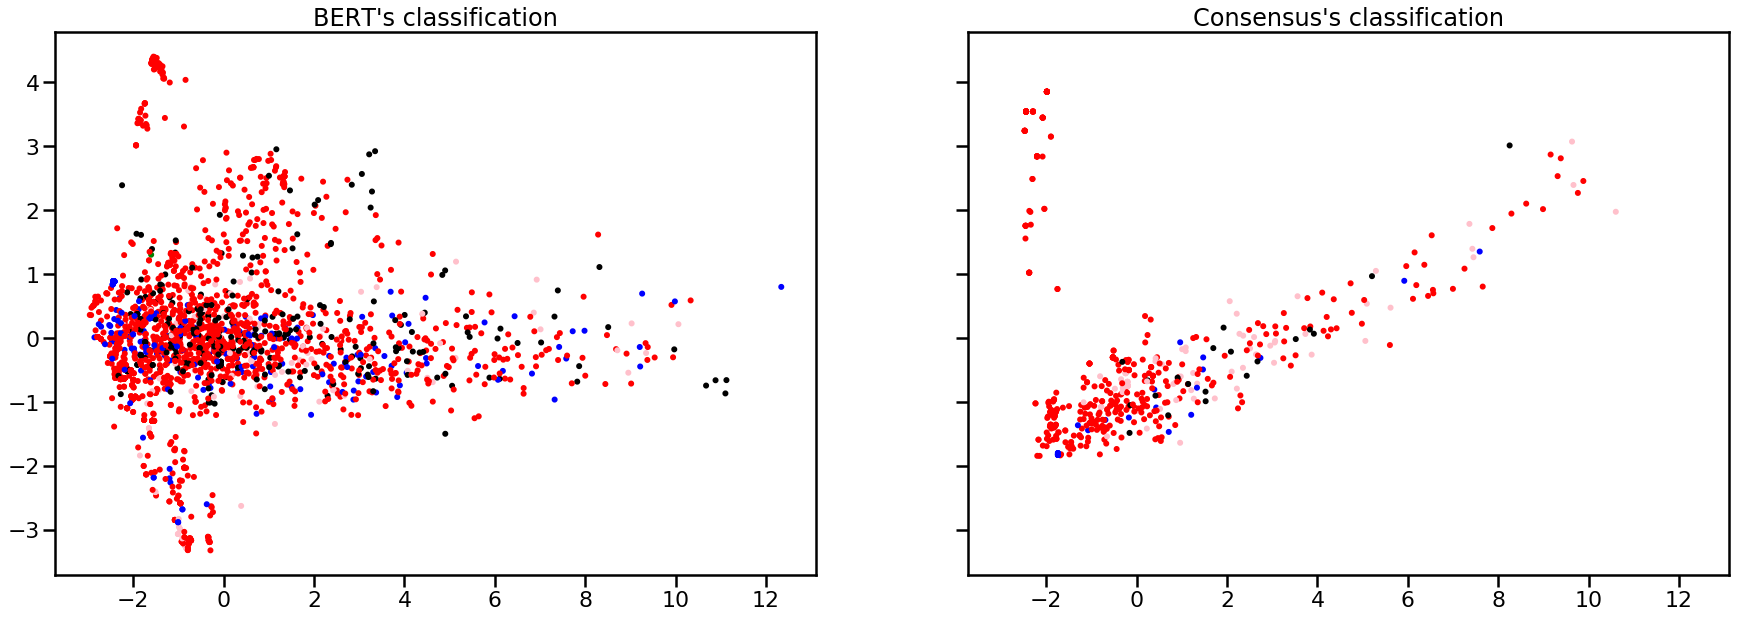

In [111]:
from sklearn.decomposition import PCA
import matplotlib
# Visualize the vectors of 2 types of situation:
# all test data, and the data with classification consensed by BERT and MLP.

# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(pd.concat([test_result['prediction'],test_result_BERT['prediction']]))

#set up colors per clusters using a dict

label_colors = {0: 'blue', 1: 'red', 2: 'black', 3: 'green', 
          4: 'orange',5:'purple',6:'grey',7:'pink'}
#set up cluster names using a dict
cat = {0: 'Authorization', 
                 1: 'Others', 
                 2: 'Project', 
                 3: 'Report', 
                 4: 'Resource',
                 5: 'SAP_HR', 
                 6: 'Subcon',
                 7: 'Timesheet'
                }

color=[]
for record in test_result_BERT['prediction']:
    i=0
    for item in list(cat.values()):
        if record==item:
            color.append(list(label_colors.values())[i])
        i +=1

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,figsize=(30,10))

#fig=plt.figure()
# Show tfidf results transformed to 2d
pcatf_2d = PCA(n_components=2).fit_transform(x_test)
axes[0].scatter(pcatf_2d[:,0],pcatf_2d[:,1],color=color,s=16)
axes[0].set_title("BERT's classification")

#plt.scatter(pcatf_2d[:,0],pcatf_2d[:,1],c=colors, **plot_kwds)

# Show counting vect results transformed to 2d
color=[]
for record in test_result_merg['prediction_x']:
    i=0
    for item in list(cat.values()):
        if record==item:
            color.append(list(label_colors.values())[i])
        i +=1
vec_merg=tokenize.texts_to_matrix(test_result_merg['sentence_x'])
pcacnt_2d = PCA(n_components=2).fit_transform(vec_merg)
axes[1].scatter(pcacnt_2d[:,0],pcacnt_2d[:,1],color=color,s=16)
axes[1].set_title("Consensus's classification")

# show scatter plots.
plt.show()
